#Setup and Imports for Text Analysis and Machine Learning

In [2]:
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#Loading Dataset from Online Source and Dropping Unnecessary Column

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/Boganatham-SuryaTeja/HouseDiscoveryPlatform-Dataset/main/hotelReviews.csv")
df = df.drop(columns=['Unnamed: 0'])

#Text Cleaning Function for Review Data

In [5]:
df['combined_reviews'] = df['reviews.title'].fillna('') + ' ' + df['reviews.text'].fillna('')
df.rename(columns={'combined_reviews': 'review'}, inplace=True)

In [6]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into text
    return ' '.join(words)

# Apply the preprocess_text function to the 'review' column in the DataFrame
df['review'] = df['review'].apply(preprocess_text)


#Sentiment Classification Function Utilizing TextBlob

In [7]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 1  # Positive
    elif polarity < -0.1:
        return -1  # Negative
    else:
        return 0  # Neutral

# Apply the analyze_sentiment function to the 'review' column in the DataFrame
df['sentiment'] = df['review'].apply(analyze_sentiment)

#Data Preparation for Modeling

In [8]:
# Extracting features and target variable
features = df['review']
target = df['sentiment']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Vectorizing the text data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


#Implementation of the Naive Bayes Model

In [10]:
# Initialize and train the Multinomial Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vectorized, y_train)

# Predict using the trained model
y_pred = naive_bayes_model.predict(X_test_vectorized)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print accuracy and classification report
print('Accuracy:', accuracy)
print('\nClassification Report:\n', classification_rep)

Accuracy: 0.8849512069851053

Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.05      0.10       151
           0       0.45      0.54      0.49       377
           1       0.94      0.96      0.95      3366

    accuracy                           0.88      3894
   macro avg       0.73      0.52      0.51      3894
weighted avg       0.89      0.88      0.87      3894



#Exploring Polarity Score Distributions

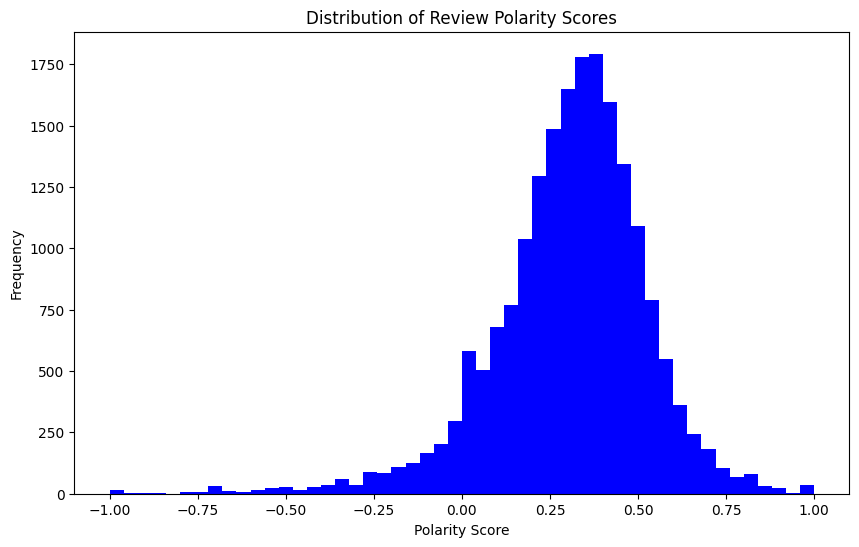

In [11]:
# Calculate polarity scores for each review
review_polarity_scores = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot the distribution of polarity scores
plt.figure(figsize=(10, 6))
plt.hist(review_polarity_scores, bins=50, color='blue')
plt.title('Distribution of Review Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

# Reanalyzing sentiment with new thresholds

In [12]:
def reanalyze_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    # New thresholds for sentiment classification
    if polarity > 0.05:
        return 1  # Positive
    elif polarity < -0.05:
        return -1  # Negative
    else:
        return 0  # Neutral

# Apply the reanalyze_sentiment function to the 'review' column in the DataFrame
df['sentiment'] = df['review'].apply(reanalyze_sentiment)


#Reapplying Naive Bayes Model with Revised Sentiment Classification

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, df['sentiment'], test_size=0.2, random_state=42)

X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

naive_bayes_model.fit(X_train_counts, y_train)

y_pred = naive_bayes_model.predict(X_test_counts)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.9070364663585002

Classification Report:
               precision    recall  f1-score   support

          -1       0.68      0.34      0.45       202
           0       0.28      0.17      0.21       198
           1       0.93      0.98      0.96      3494

    accuracy                           0.91      3894
   macro avg       0.63      0.50      0.54      3894
weighted avg       0.89      0.91      0.89      3894



#Utilizing SMOTE for Training Data Imbalance Correction

In [14]:
# Initialize and fit CountVectorizer
text_vectorizer = CountVectorizer()
X_vectorized = text_vectorizer.fit_transform(df['review'])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, df['sentiment'], test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the model
naive_bayes_model.fit(X_train_smote, y_train_smote)

# Predictions and evaluation
y_pred = naive_bayes_model.predict(X_test)
print('Model Evaluation')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Model Evaluation
Accuracy: 0.8983050847457628
Classification Report:
               precision    recall  f1-score   support

          -1       0.60      0.52      0.56       202
           0       0.28      0.37      0.32       198
           1       0.96      0.95      0.96      3494

    accuracy                           0.90      3894
   macro avg       0.61      0.61      0.61      3894
weighted avg       0.91      0.90      0.90      3894



In [15]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'k-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    print(f"\n{name} Model Evaluation")
    print('Accuracy:', accuracy)
    print('Classification Report:\n', classification_rep)


Training Logistic Regression...

Logistic Regression Model Evaluation
Accuracy: 0.9093477144324602
Classification Report:
               precision    recall  f1-score   support

          -1       0.64      0.62      0.63       202
           0       0.30      0.42      0.35       198
           1       0.98      0.95      0.96      3494

    accuracy                           0.91      3894
   macro avg       0.64      0.67      0.65      3894
weighted avg       0.92      0.91      0.92      3894


Training Decision Tree...

Decision Tree Model Evaluation
Accuracy: 0.8479712378017463
Classification Report:
               precision    recall  f1-score   support

          -1       0.35      0.48      0.41       202
           0       0.18      0.32      0.23       198
           1       0.96      0.90      0.93      3494

    accuracy                           0.85      3894
   macro avg       0.50      0.57      0.52      3894
weighted avg       0.89      0.85      0.87      3894


T

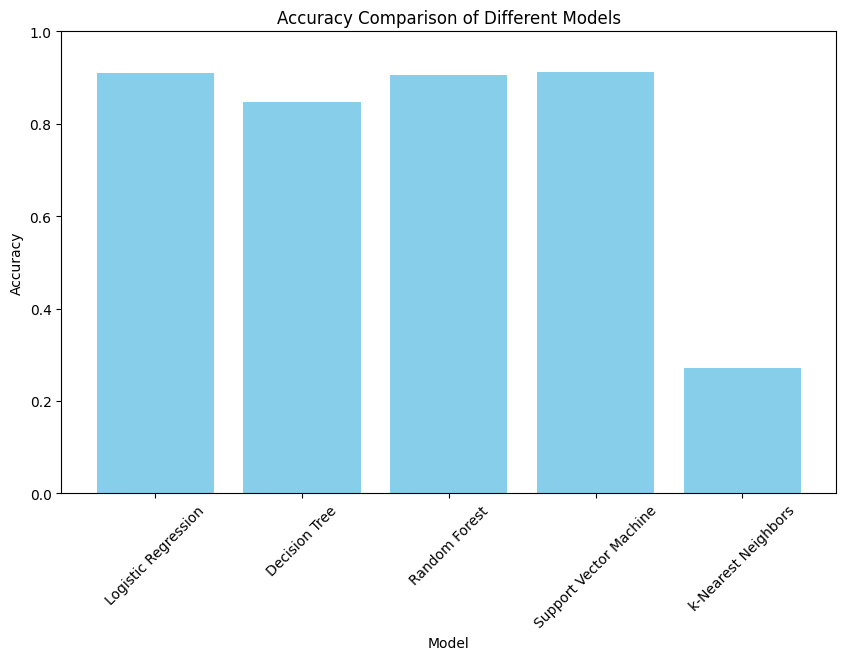

In [16]:
import matplotlib.pyplot as plt

# Extract accuracy values for each model
accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in models.values()]

# Plot accuracy comparison bar chart
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


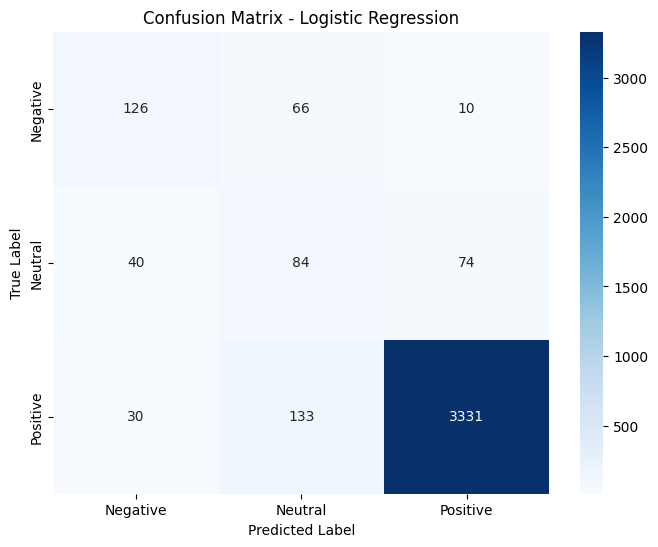

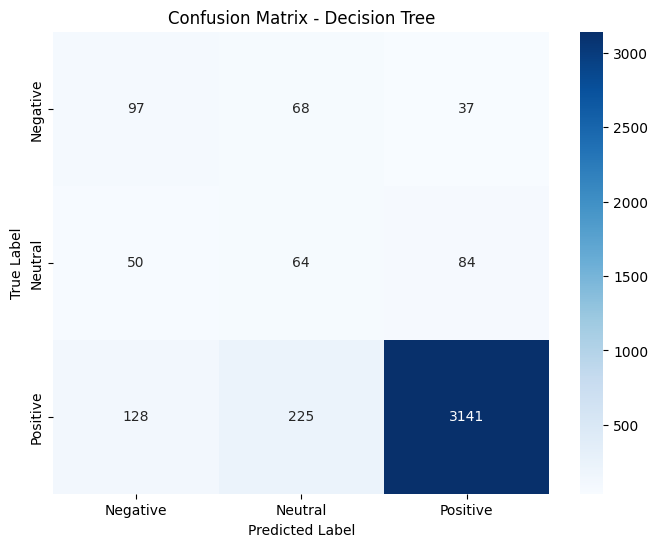

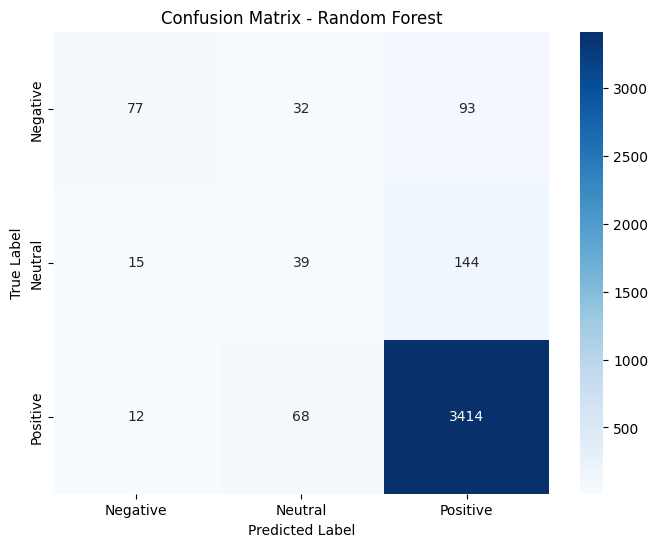

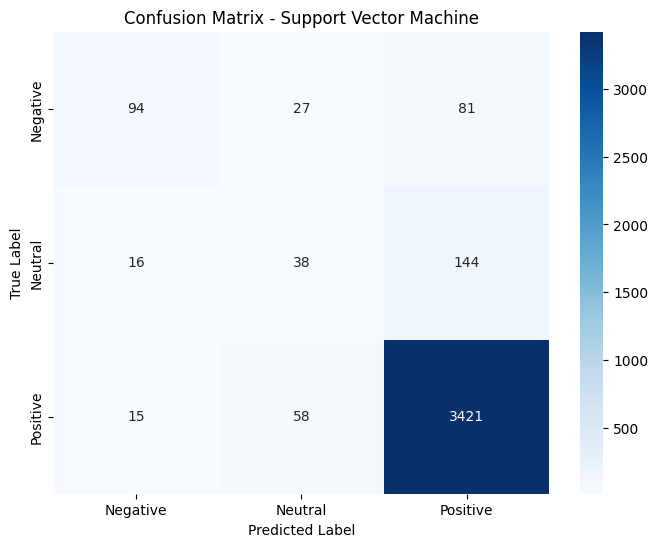

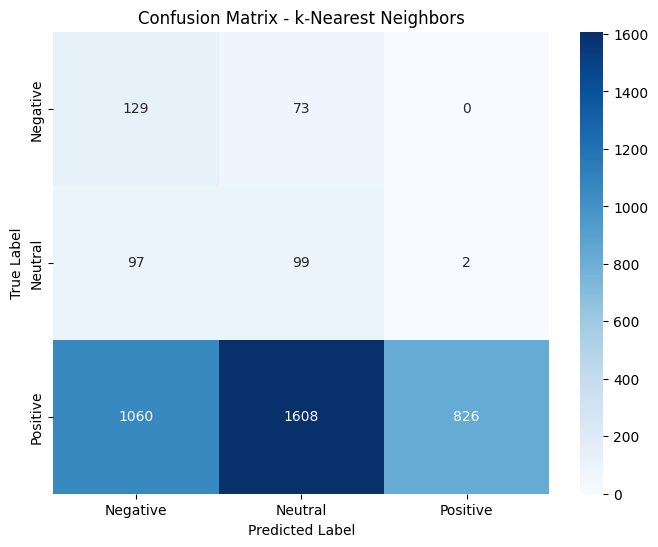

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot confusion matrix heatmap for each model
for name, model in models.items():
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


#Applying Logistic regression

In [18]:
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train_smote, y_train_smote)

# Predictions and evaluation for Logistic Regression
y_pred_logreg = logistic_regression_model.predict(X_test)
print('\nLogistic Regression Model Evaluation')
print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('Classification Report:\n', classification_report(y_test, y_pred_logreg))


Logistic Regression Model Evaluation
Accuracy: 0.9093477144324602
Classification Report:
               precision    recall  f1-score   support

          -1       0.64      0.62      0.63       202
           0       0.30      0.42      0.35       198
           1       0.98      0.95      0.96      3494

    accuracy                           0.91      3894
   macro avg       0.64      0.67      0.65      3894
weighted avg       0.92      0.91      0.92      3894



#Saving the Trained Naive Bayes Model Using Pickle

In [19]:
import pickle

In [20]:
pickle.dump(logistic_regression_model,open('LogisticRegression.pkl',"wb"))